In [1]:
import pandas as pd
import psycopg2
import numpy as np
from geopy.distance import great_circle
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## 1. Extract GPS data from database

In [2]:
%%time
conn = psycopg2.connect(
    dbname = "gisdb", 
    user = "postgres",
    password =  "task4TH",
    host = "localhost"
)

# Query data from 2023-07-22 to the following week
query = """
WITH user_log_count AS (
    SELECT uuid, COUNT(*) AS log_count
    FROM blogwatcher.gps_logs
    WHERE logtime BETWEEN '2023-07-22' AND '2023-07-29'
    GROUP BY uuid
),
top_1_percent_users AS (
    -- Find users in the top 1% of log count
    SELECT uuid
    FROM user_log_count
    WHERE log_count >= (SELECT PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY log_count) FROM user_log_count)
)
SELECT 
    gps_logs.uuid,  
    gps_logs.logtime, 
    gps_logs.accuracy, 
    gps_logs.ios, 
    ST_AsText(gps_logs.geom) AS geom
FROM blogwatcher.gps_logs gps_logs
JOIN top_1_percent_users t1p ON gps_logs.uuid = t1p.uuid
WHERE gps_logs.logtime BETWEEN '2023-07-22' AND '2023-07-29'
ORDER BY gps_logs.uuid, gps_logs.logtime;
"""

# Extract data
gps_data = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# If the number of users exceeds 2000, randomly select 2000 users
top_users = gps_data['uuid'].unique()
if len(top_users) > 20:
    selected_users = np.random.choice(top_users, 20, replace=False)
    gps_data = gps_data[gps_data['uuid'].isin(selected_users)]

print(f"Selected {len(gps_data['uuid'].unique())} users for analysis.")

<timed exec>:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


Selected 20 users for analysis.
CPU times: user 1min 12s, sys: 18 s, total: 1min 30s
Wall time: 10min 19s


In [3]:
gps_data

,uuid,logtime,accuracy,ios,geom
1563090,05602b5d-9aae-ca53-2db7-fd6135c50c27,2023-07-22 00:02:12,35.240,True,POINT(139.3368887 35.7104118)
1563091,05602b5d-9aae-ca53-2db7-fd6135c50c27,2023-07-22 00:02:14,35.000,True,POINT(139.3366246 35.7100865)
1563092,05602b5d-9aae-ca53-2db7-fd6135c50c27,2023-07-22 00:02:48,35.000,True,POINT(139.3366675 35.7101305)
1563093,05602b5d-9aae-ca53-2db7-fd6135c50c27,2023-07-22 00:07:14,35.000,True,POINT(139.3366929 35.7100981)
1563094,05602b5d-9aae-ca53-2db7-fd6135c50c27,2023-07-22 00:11:48,35.130,True,POINT(139.3366891 35.7100865)
...,...,...,...,...,...
69526993,f0881733-d751-57be-d1be-2f379dbf1972,2023-07-28 20:40:15,8.509,True,POINT(139.7133423 35.6451194)
69526994,f0881733-d751-57be-d1be-2f379dbf1972,2023-07-28 20:40:32,8.880,True,POINT(139.713342 35.6451203)
69526995,f0881733-d751-57be-d1be-2f379dbf1972,2023-07-28 20:41:05,8.980,True,POINT(139.7133426 35.6451199)
69526996,f0881733-d751-57be-d1be-2f379dbf1972,2023-07-28 20:41:17,9.080,True,POINT(139.7133425 35.6451203)


## 2. Analyze user activities by date
For each user on each day, calculate: a) Radius of gyration, b) Number of visited locations, c) Duration of stay at each location.
Calculate the radius of gyration and the number of visited locations:

In [4]:
def extract_lat_lon(group):
    group['latitude'] = group['geom'].apply(lambda x: float(x.split()[1][:-1]))   # Extract latitude
    group['longitude'] = group['geom'].apply(lambda x: float(x.split()[0].split('(')[1]))  # Extract longitude
    return group

def calculate_radius_of_gyration(group):
    coords = group[['latitude', 'longitude']].to_numpy()
    centroid = coords.mean(axis=0)  # Calculate the centroid
    radius_of_gyration = np.sqrt(np.mean([great_circle(coord, centroid).meters**2 for coord in coords]))
    return radius_of_gyration

def calculate_number_of_locations(group, epsilon=100, min_samples=3):
    coords = group[['latitude', 'longitude']].to_numpy()
    db = DBSCAN(eps=epsilon, min_samples=min_samples, metric=lambda x, y: great_circle(x, y).meters).fit(coords)
    return len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)  # Exclude noise points (-1)

# Calculate the stay time at each location
def calculate_stay_times(group, epsilon=100, min_samples=3, time_threshold=3600):
    coords = group[['latitude', 'longitude']].to_numpy()
    db = DBSCAN(eps=epsilon, min_samples=min_samples, metric=lambda x, y: great_circle(x, y).meters).fit(coords)
    group['cluster'] = db.labels_

    clustered_points = group[group['cluster'] != -1].copy()
    clustered_points['visit_id'] = 0
    clustered_points['prev_logtime'] = clustered_points['logtime'].shift(1)
    clustered_points['time_diff'] = (clustered_points['logtime'] - clustered_points['prev_logtime']).dt.total_seconds()

    visit_id = 0
    for idx, row in clustered_points.iterrows():
        if pd.isnull(row['time_diff']) or row['time_diff'] > time_threshold:
            visit_id += 1
        clustered_points.at[idx, 'visit_id'] = visit_id

    stay_summary = clustered_points.groupby('visit_id').agg({
        'logtime': ['min', 'max'],
        'latitude': 'mean',
        'longitude': 'mean'
    })

    stay_summary['duration'] = (stay_summary[('logtime', 'max')] - stay_summary[('logtime', 'min')]).dt.total_seconds()
    return stay_summary['duration'].values  # Return the duration of each stay

## 3. Analyze and visualize data by date
For each day and each user, calculate their radius of gyration, number of visited locations, and stay times. Then, visualize the daily distributions.

In [5]:
%%time

results = {'date': [], 'uuid': [], 'radius_of_gyration': [], 'num_locations': [], 'avg_stay_time': []}

gps_data = extract_lat_lon(gps_data)

for date, date_group in gps_data.groupby(gps_data['logtime'].dt.date):
    for uuid, user_group in date_group.groupby('uuid'):
        radius_of_gyration = calculate_radius_of_gyration(user_group)
        num_locations = calculate_number_of_locations(user_group)
        stay_times = calculate_stay_times(user_group)

        results['date'].append(date)
        results['uuid'].append(uuid)
        results['radius_of_gyration'].append(radius_of_gyration)
        results['num_locations'].append(num_locations)
        results['avg_stay_time'].append(np.mean(stay_times) if len(stay_times) > 0 else 0)

# Convert to DataFrame
results_df = pd.DataFrame(results)

CPU times: user 2min 14s, sys: 25.7 ms, total: 2min 14s
Wall time: 2min 19s


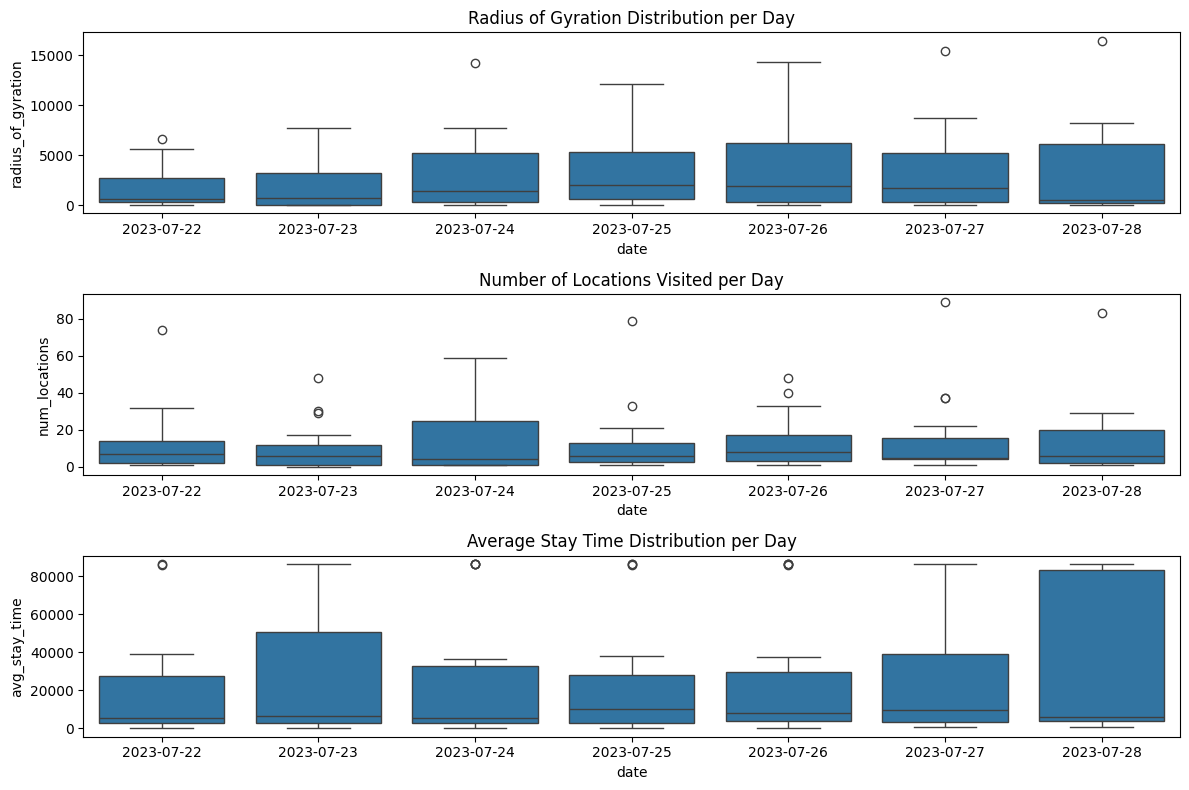

In [6]:
# Visualize daily distributions
plt.figure(figsize=(12, 8))

# Distribution of radius of gyration
plt.subplot(3, 1, 1)
sns.boxplot(x='date', y='radius_of_gyration', data=results_df)
plt.title('Radius of Gyration Distribution per Day')

# Distribution of number of visited locations
plt.subplot(3, 1, 2)
sns.boxplot(x='date', y='num_locations', data=results_df)
plt.title('Number of Locations Visited per Day')

# Distribution of average stay time
plt.subplot(3, 1, 3)
sns.boxplot(x='date', y='avg_stay_time', data=results_df)
plt.title('Average Stay Time Distribution per Day')

plt.tight_layout()
plt.show()

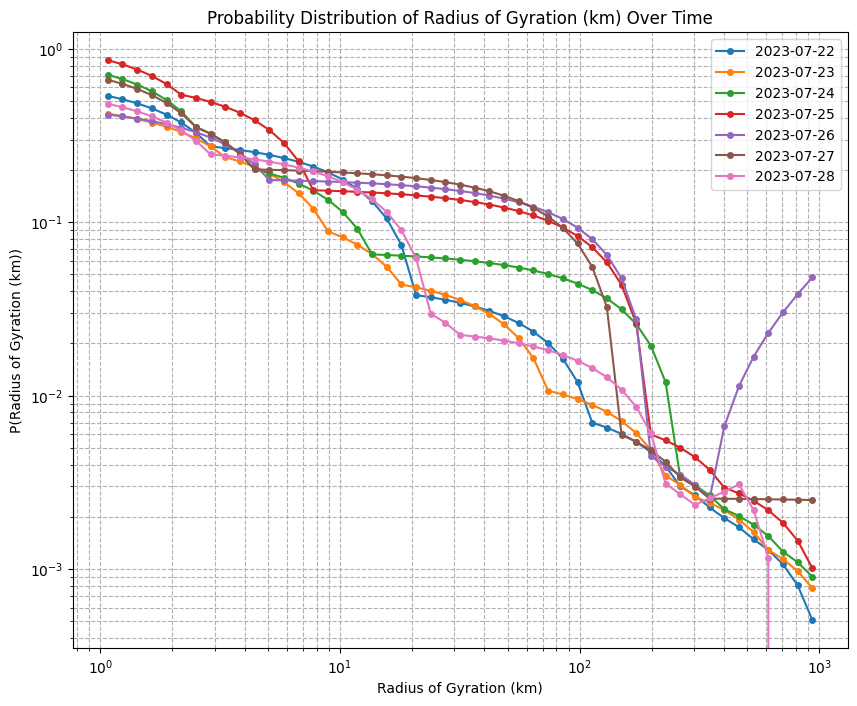

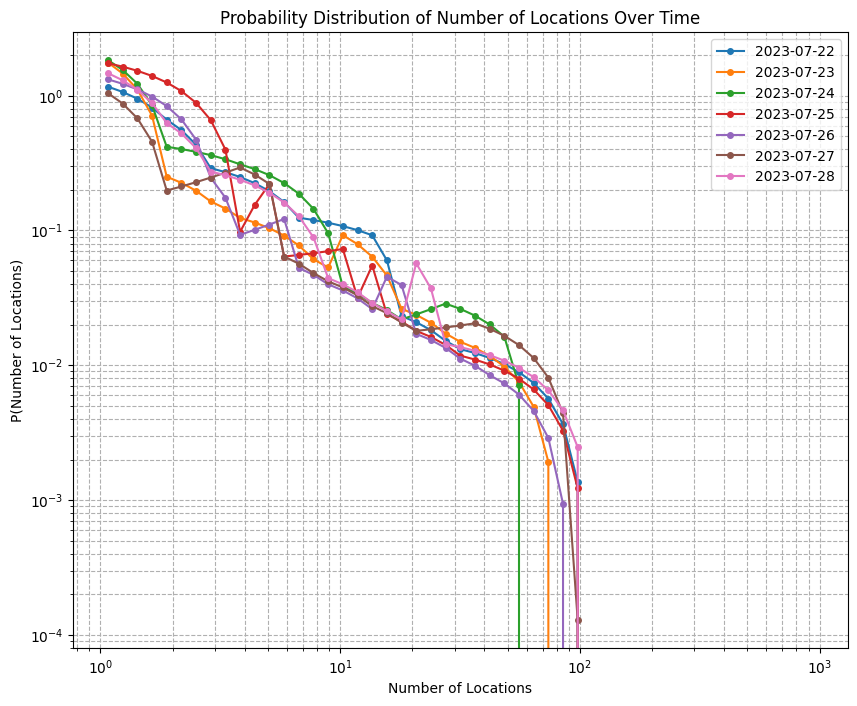

/home/owner/.local/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


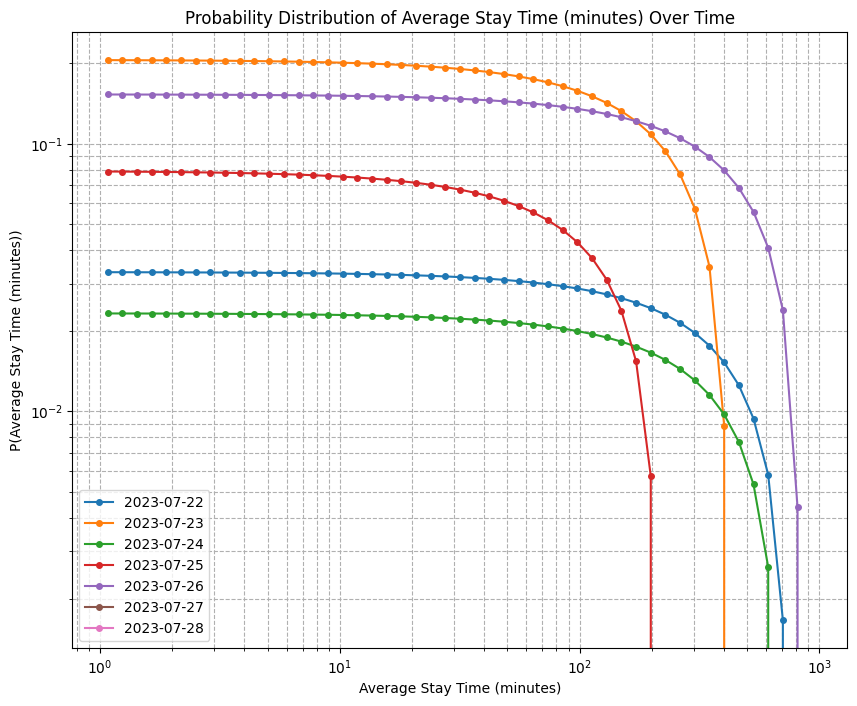

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d


# New visualization function for radius of gyration and other metrics
def visualize_metrics_over_dates(df, metric, metric_label):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    plt.figure(figsize=(10, 8))

    # Loop through each unique date in the data
    for start_time in df.index.unique():
        # Filter the data for the specific date
        metric_values = df[df.index == start_time][metric].dropna().values

        if len(metric_values) > 0:
            # Compute histogram for the metric values
            hist, bin_edges = np.histogram(
                metric_values, bins=np.logspace(np.log10(1), np.log10(1000), 50), density=True
            )
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

            hist = np.where(hist == 0, np.nan, hist)

            # Perform interpolation to fill in NaN values or missing points
            # Here, we use 'linear' interpolation, but you can experiment with 'quadratic' or 'cubic' as well
            valid = ~np.isnan(hist)
            interpolator = interp1d(bin_centers[valid], hist[valid], kind='linear', fill_value="extrapolate")
    
            # Interpolating the missing data points
            hist_interpolated = interpolator(bin_centers)

            # Plot the histogram on a log-log scale
            plt.plot(bin_centers, hist_interpolated, '-o', label=f'{start_time.strftime("%Y-%m-%d")}', markersize=4)


    # Add labels, title, and grid to the plot
    plt.xscale('log')  # Log scale for x-axis
    plt.yscale('log')  # Log scale for y-axis
    plt.xlabel(f'{metric_label}')
    plt.ylabel(f'P({metric_label})')
    plt.title(f'Probability Distribution of {metric_label} Over Time')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()


# Visualize radius of gyration over actual dates
visualize_metrics_over_dates(
    results_df, 
    metric='radius_of_gyration', 
    metric_label='Radius of Gyration (km)'
)

# Visualize number of locations visited over actual dates
visualize_metrics_over_dates(
    results_df, 
    metric='num_locations', 
    metric_label='Number of Locations'
)

# Visualize average stay time over actual dates
visualize_metrics_over_dates(
    results_df, 
    metric='avg_stay_time', 
    metric_label='Average Stay Time (minutes)'
)

In [8]:
results_df

,date,uuid,radius_of_gyration,num_locations,avg_stay_time
0,2023-07-22,05602b5d-9aae-ca53-2db7-fd6135c50c27,276.505402,3,33601.500000
1,2023-07-22,10a67ef7-b4f4-fb28-57bc-ebf3cdd6f6d2,348.750586,2,130.000000
2,2023-07-22,1298bef7-2be5-5d7a-7e0b-9762362619ec,22.070140,1,86058.000000
3,2023-07-22,192b52e7-e4e7-a7d5-7d32-6372377d68d0,5582.745833,13,23256.000000
4,2023-07-22,1b46126a-e20f-65c3-f60d-f4c618d6924a,650.931917,3,1061.000000
...,...,...,...,...,...
122,2023-07-28,a12b0a49-d337-14a3-e088-f200d172c02d,1386.085227,3,966.000000
123,2023-07-28,d10e045b-8606-c51c-449d-48f02a739530,16444.016278,29,5096.666667
124,2023-07-28,d360de62-5110-bdf3-858b-00414831ba65,464.150757,9,86100.000000
125,2023-07-28,eb0e35f7-f173-7d27-d582-e51f1a8c9af8,7214.415681,16,86124.000000


## 4. Calucalte and visualize jump lengths

In [9]:
# Function to calculate the distances (jump lengths) between consecutive stay points
def calculate_jump_lengths(group, epsilon=100, min_samples=3, time_threshold=3600):
    coords = group[['latitude', 'longitude']].to_numpy()
    db = DBSCAN(eps=epsilon, min_samples=min_samples, metric=lambda x, y: great_circle(x, y).meters).fit(coords)
    group['cluster'] = db.labels_

    clustered_points = group[group['cluster'] != -1].copy()
    clustered_points['visit_id'] = 0
    clustered_points['prev_logtime'] = clustered_points['logtime'].shift(1)
    clustered_points['time_diff'] = (clustered_points['logtime'] - clustered_points['prev_logtime']).dt.total_seconds()

    visit_id = 0
    for idx, row in clustered_points.iterrows():
        if pd.isnull(row['time_diff']) or row['time_diff'] > time_threshold:
            visit_id += 1
        clustered_points.at[idx, 'visit_id'] = visit_id

    # Get jump lengths (distance between consecutive stay points)
    clustered_points = clustered_points.drop_duplicates('visit_id')
    clustered_points['next_latitude'] = clustered_points['latitude'].shift(-1)
    clustered_points['next_longitude'] = clustered_points['longitude'].shift(-1)
    
    # Calculate the jump lengths (distances between consecutive points)
    clustered_points['jump_length'] = clustered_points.apply(
        lambda row: great_circle(
            (row['latitude'], row['longitude']), (row['next_latitude'], row['next_longitude'])
        ).meters if not pd.isnull(row['next_latitude']) else None, axis=1
    )
    
    # Return jump lengths (filter out None values)
    return clustered_points['jump_length'].dropna().values


# New visualization function for jump lengths over time
def visualize_jump_lengths_over_dates(df, metric_label):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    plt.figure(figsize=(10, 8))

    # Loop through each unique date in the data
    for start_time in df.index.unique():
        # Filter the data for the specific date
        jump_lengths = df[df.index == start_time]['jump_lengths'].dropna().values

        if len(jump_lengths) > 0:
            # Compute histogram for the jump lengths
            hist, bin_edges = np.histogram(
                jump_lengths, bins=np.logspace(np.log10(1), np.log10(100000), 50), density=True
            )
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

            hist = np.where(hist == 0, np.nan, hist)

            # Perform interpolation to fill in NaN values or missing points
            # Here, we use 'linear' interpolation, but you can experiment with 'quadratic' or 'cubic' as well
            valid = ~np.isnan(hist)
            interpolator = interp1d(bin_centers[valid], hist[valid], kind='linear', fill_value="extrapolate")
    
            # Interpolating the missing data points
            hist_interpolated = interpolator(bin_centers)

            # Plot the histogram on a log-log scale
            plt.plot(bin_centers, hist_interpolated, '-o', label=f'{start_time.strftime("%Y-%m-%d")}', markersize=4)


    # Add labels, title, and grid to the plot
    plt.xscale('log')  # Log scale for x-axis
    plt.yscale('log')  # Log scale for y-axis
    plt.xlabel(f'{metric_label}')
    plt.ylabel(f'P({metric_label})')
    plt.title(f'Probability Distribution of {metric_label} Over Time')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

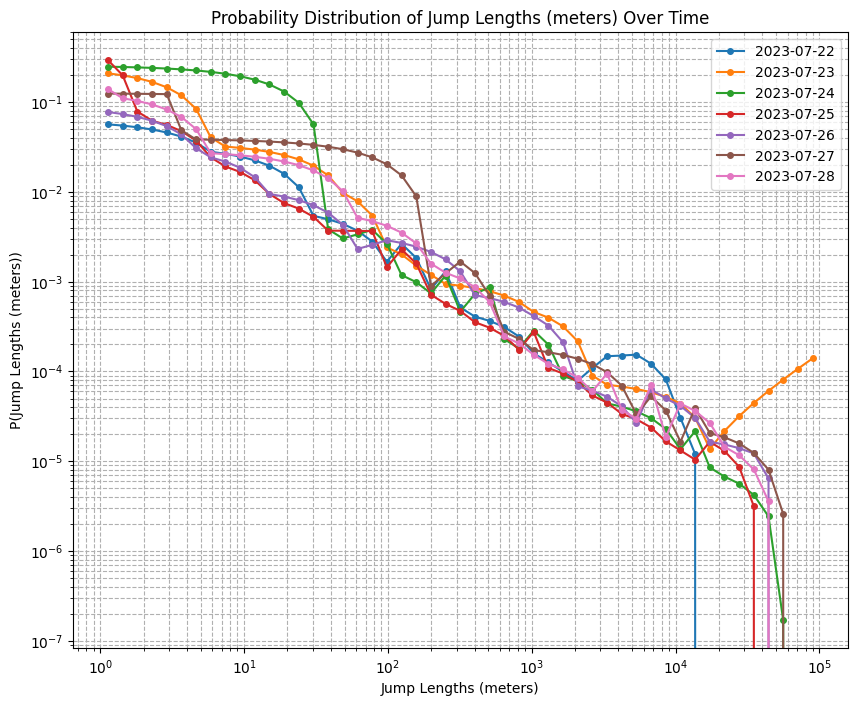

In [11]:
%%time

# For each user and each day, calculate jump lengths
jump_results = {'date': [], 'uuid': [], 'jump_lengths': []}

for date, date_group in gps_data.groupby(gps_data['logtime'].dt.date):
    for uuid, user_group in date_group.groupby('uuid'):
        jump_lengths = calculate_jump_lengths(user_group)
        if len(jump_lengths) > 0:
            jump_results['date'].extend([date] * len(jump_lengths))
            jump_results['uuid'].extend([uuid] * len(jump_lengths))
            jump_results['jump_lengths'].extend(jump_lengths)

# Convert to DataFrame
jump_results_df = pd.DataFrame(jump_results)

# Visualize the distribution of jump lengths
visualize_jump_lengths_over_dates(
    jump_results_df, 
    metric_label='Jump Lengths (meters)'
)